In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
%matplotlib inline


from pclib.nn.models import ConvClassifierUs
from pclib.nn.layers import Conv2d
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity
from pclib.utils.customdataset import PreloadedDataset

In [2]:
seed = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)
class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class PadTransform(object):
    def __call__(self, img):
        return F.pad(img, (2, 2, 2, 2), mode='constant', value=0)

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

class AddTransform(object):
    def __init__(self, add):
        self.add = add

    def __call__(self, img):
        return img + self.add

train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
    # AddTransform(0.4242),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # AddTransform(0.4242),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

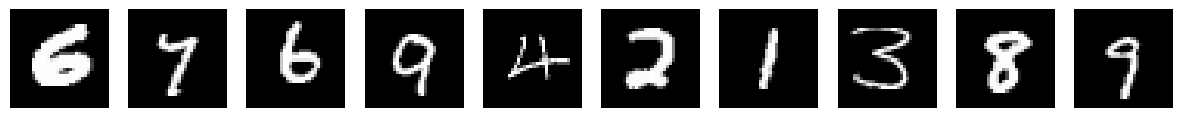

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [7]:
torch.manual_seed(seed)

model_name = 'identity-2phase-norm_weights-no_mom'
model = ConvClassifierUs(
    bias=True,
    symmetric=True, 
    actv_fn=identity,
    steps=60,
    gamma=0.1,
    ).to(device)

In [8]:
# Train Loop
BATCH_SIZE = 1000

log_dir = f'examples/mnist/logs/conv_grad/{model_name}'

NUM_EPOCHS = 50
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.00001,
    c_lr=0.0,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    save_best=False,
    optim='AdamW',
    grad_mode='auto',
    log_dir=log_dir,
    minimal_stats=True,
    scheduler='ReduceLROnPlateau',
    track_corr=True,
    track_sparsity=True,
    no_momentum=True,
)
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0,
    c_lr=0.001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    save_best=False,
    optim='AdamW',
    grad_mode='auto',
    log_dir=log_dir,
    minimal_stats=True,
    scheduler='ReduceLROnPlateau',
    track_corr=True,
    track_sparsity=True,
)

In [9]:
in_features = 2
out_features = 10
conv = torch.nn.Conv2d(in_features, out_features, kernel_size=1, bias=True).to(device)
linear = torch.nn.Linear(in_features, out_features, bias=True).to(device)

linear.weight.data.shape, conv.weight.data.shape

(torch.Size([10, 2]), torch.Size([10, 2, 1, 1]))

In [ ]:
kernel = 3
padding = 1
stride = 1
in_features = 1
out_features = 4

conv = torch.nn.Conv2d(in_features, out_features, kernel, stride, padding)
convt = torch.nn.ConvTranspose2d(out_features, in_features, kernel, stride, padding)

x = torch.randn(1, 1, 28, 28)
y = conv(x)
x_hat = convt(y)

print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")
print(f"x_hat.shape: {x_hat.shape}")


In [ ]:
targets = torch.arange(NUM_CLASSES).to(device)
y = format_y(targets, NUM_CLASSES)
_, state = model(y=y, lmda=0.00)
images = state[-1]['x']

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

In [ ]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [ ]:
def run():
    x = torch.randn(1000, 1, 28, 28).to(device)
    out = model(x, steps=100)

%timeit run()
for p in model.parameters():
    p.requires_grad = False
%timeit run()

In [ ]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

In [ ]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

In [ ]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images
y = format_y(y, 10)

track_vfe(model, x, y, 100, plot_Es=True)

In [ ]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()
